In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib

In [2]:
import os
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

file_path_train = '/content/drive/My Drive/lt_train-2.csv'


train_df = pd.read_csv(file_path_train)

In [4]:

file_path_test = '/content/drive/My Drive/lt_test-2.csv'

test_df = pd.read_csv(file_path_test)

In [5]:
train_df

,period_dt,NUM_CONSULTANT,PRICE_AFTER_DISC,PRICE_REGULAR,PRODUCT_LVL_RK6,PROMO1_FLAG,PROMO2_FLAG,STORE_LOCATION_LVL_RK2,STORE_LOCATION_LVL_RK3,STORE_LOCATION_LVL_RK4,demand,location_id,product_id,id
0,2019-04-08,0.0,1049.00,1049.0,9988,1.0,0.0,10,203,203,NaN,425,19474,0
1,2017-05-08,0.0,474.50,949.0,9988,0.0,0.0,10,189,189,1.016438,453,19474,1
2,2017-05-15,0.0,474.50,949.0,9988,0.0,0.0,10,189,189,0.019178,453,19474,2
3,2017-05-22,0.0,474.50,949.0,9988,0.0,0.0,10,189,189,0.019178,453,19474,3
4,2017-05-29,0.0,474.50,949.0,9988,1.0,0.0,10,189,189,0.016438,453,19474,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550139,2019-12-23,0.0,699.50,1399.0,113176,1.0,0.0,10,203,203,NaN,1326,148464,550139
550140,2019-12-30,0.0,699.50,1399.0,113176,1.0,0.0,10,203,203,NaN,1326,148464,550140
550141,2019-12-23,0.0,699.50,1399.0,113176,1.0,0.0,10,219,219,NaN,1380,148464,550141
550142,2019-12-30,0.0,699.50,1399.0,113176,1.0,0.0,10,219,219,NaN,1380,148464,550142


In [34]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 471021 entries, 0 to 550143
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   period_dt               471021 non-null  datetime64[ns]
 1   NUM_CONSULTANT          470895 non-null  float64       
 2   PRICE_AFTER_DISC        466904 non-null  float64       
 3   PRICE_REGULAR           469511 non-null  float64       
 4   PRODUCT_LVL_RK6         471021 non-null  int64         
 5   PROMO1_FLAG             470895 non-null  float64       
 6   PROMO2_FLAG             470895 non-null  float64       
 7   STORE_LOCATION_LVL_RK2  471021 non-null  int64         
 8   STORE_LOCATION_LVL_RK3  471021 non-null  int64         
 9   STORE_LOCATION_LVL_RK4  471021 non-null  int64         
 10  demand                  263270 non-null  float64       
 11  location_id             471021 non-null  int64         
 12  product_id              471021 non-

In [35]:
train_df.describe()

,period_dt,NUM_CONSULTANT,PRICE_AFTER_DISC,PRICE_REGULAR,PRODUCT_LVL_RK6,PROMO1_FLAG,PROMO2_FLAG,STORE_LOCATION_LVL_RK2,STORE_LOCATION_LVL_RK3,STORE_LOCATION_LVL_RK4,...,month,day,season_Spring,season_Summer,season_Winter,weekday,is_weekend,launch_date,days_since_launch,early_life_cycle_end
count,471021,470895.000000,466904.000000,469511.000000,471021.000000,470895.00000,470895.000000,471021.0,471021.000000,471021.000000,...,471021.000000,471021.000000,471021.000000,471021.000000,471021.000000,471021.0,471021.0,471021,471021.000000,471021
mean,2018-10-18 10:44:06.225964800,0.351768,1113.102975,1709.852681,93368.156086,0.71451,0.003096,10.0,147.581191,147.581191,...,6.798353,15.621340,0.237894,0.258343,0.237104,0.0,0.0,2017-11-16 17:36:27.991618560,335.713637,2017-12-14 17:36:27.991618560
min,2017-01-02 00:00:00,0.000000,2.490000,110.000000,4306.000000,0.00000,0.000000,10.0,25.000000,25.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,2017-01-02 00:00:00,0.000000,2017-01-30 00:00:00
25%,2018-04-02 00:00:00,0.000000,780.000000,1349.000000,113162.000000,0.00000,0.000000,10.0,54.000000,54.000000,...,4.000000,8.000000,0.000000,0.000000,0.000000,0.0,0.0,2017-03-20 00:00:00,126.000000,2017-04-17 00:00:00
50%,2018-11-19 00:00:00,0.000000,1001.857143,1599.000000,113176.000000,1.00000,0.000000,10.0,189.000000,189.000000,...,7.000000,16.000000,0.000000,0.000000,0.000000,0.0,0.0,2017-11-13 00:00:00,287.000000,2017-12-11 00:00:00
75%,2019-06-03 00:00:00,0.000000,1311.750000,2049.000000,113176.000000,1.00000,0.000000,10.0,203.000000,203.000000,...,10.000000,23.000000,0.000000,1.000000,0.000000,0.0,0.0,2018-04-09 00:00:00,504.000000,2018-05-07 00:00:00
max,2019-12-30 00:00:00,7.000000,5049.000000,5149.000000,113182.000000,2.00000,1.000000,10.0,258.000000,258.000000,...,12.000000,31.000000,1.000000,1.000000,1.000000,0.0,0.0,2019-12-30 00:00:00,1092.000000,2020-01-27 00:00:00
std,NaN,1.234102,482.778804,674.650088,40825.101121,0.55078,0.055558,0.0,76.673535,76.673535,...,3.409861,8.818393,0.425794,0.437724,0.425307,0.0,0.0,NaN,250.065929,NaN


In [31]:
unique_counts = train_df.nunique()
percent_unique = (unique_counts / len(train_df)) * 100
zero_counts = (train_df == 0).sum()
percent_zero = (zero_counts / len(train_df)) * 100
null_counts = train_df.isnull().sum()
percent_null = (null_counts / len(train_df)) * 100

In [32]:
summary_df = pd.DataFrame({
        'Column': train_df.columns,
        'Unique': unique_counts,
        '%unique': percent_unique,
        'Zero': zero_counts,
        '%zero': percent_zero,
        'Null': null_counts,
        '%null': percent_null
    })

In [33]:
summary_df

,Column,Unique,%unique,Zero,%zero,Null,%null
period_dt,period_dt,157,0.033332,0,0.000000,0,0.000000
NUM_CONSULTANT,NUM_CONSULTANT,8,0.001698,432085,91.733702,126,0.026750
PRICE_AFTER_DISC,PRICE_AFTER_DISC,7389,1.568720,0,0.000000,4117,0.874059
PRICE_REGULAR,PRICE_REGULAR,1298,0.275572,0,0.000000,1510,0.320580
PRODUCT_LVL_RK6,PRODUCT_LVL_RK6,18,0.003821,0,0.000000,0,0.000000
PROMO1_FLAG,PROMO1_FLAG,3,0.000637,157833,33.508697,126,0.026750
PROMO2_FLAG,PROMO2_FLAG,2,0.000425,469437,99.663709,126,0.026750
STORE_LOCATION_LVL_RK2,STORE_LOCATION_LVL_RK2,1,0.000212,0,0.000000,0,0.000000
STORE_LOCATION_LVL_RK3,STORE_LOCATION_LVL_RK3,13,0.002760,0,0.000000,0,0.000000
STORE_LOCATION_LVL_RK4,STORE_LOCATION_LVL_RK4,13,0.002760,0,0.000000,0,0.000000


In [6]:
test_df

,product_id,location_id,period_dt,id
0,19474,425,2019-04-08,0
1,19581,862,2019-04-08,1772
2,19581,862,2019-04-15,1773
3,19581,862,2019-04-22,1774
4,19581,862,2019-04-29,1775
...,...,...,...,...
34102,148464,1326,2019-12-23,550139
34103,148464,1326,2019-12-30,550140
34104,148464,1380,2019-12-23,550141
34105,148464,1380,2019-12-30,550142


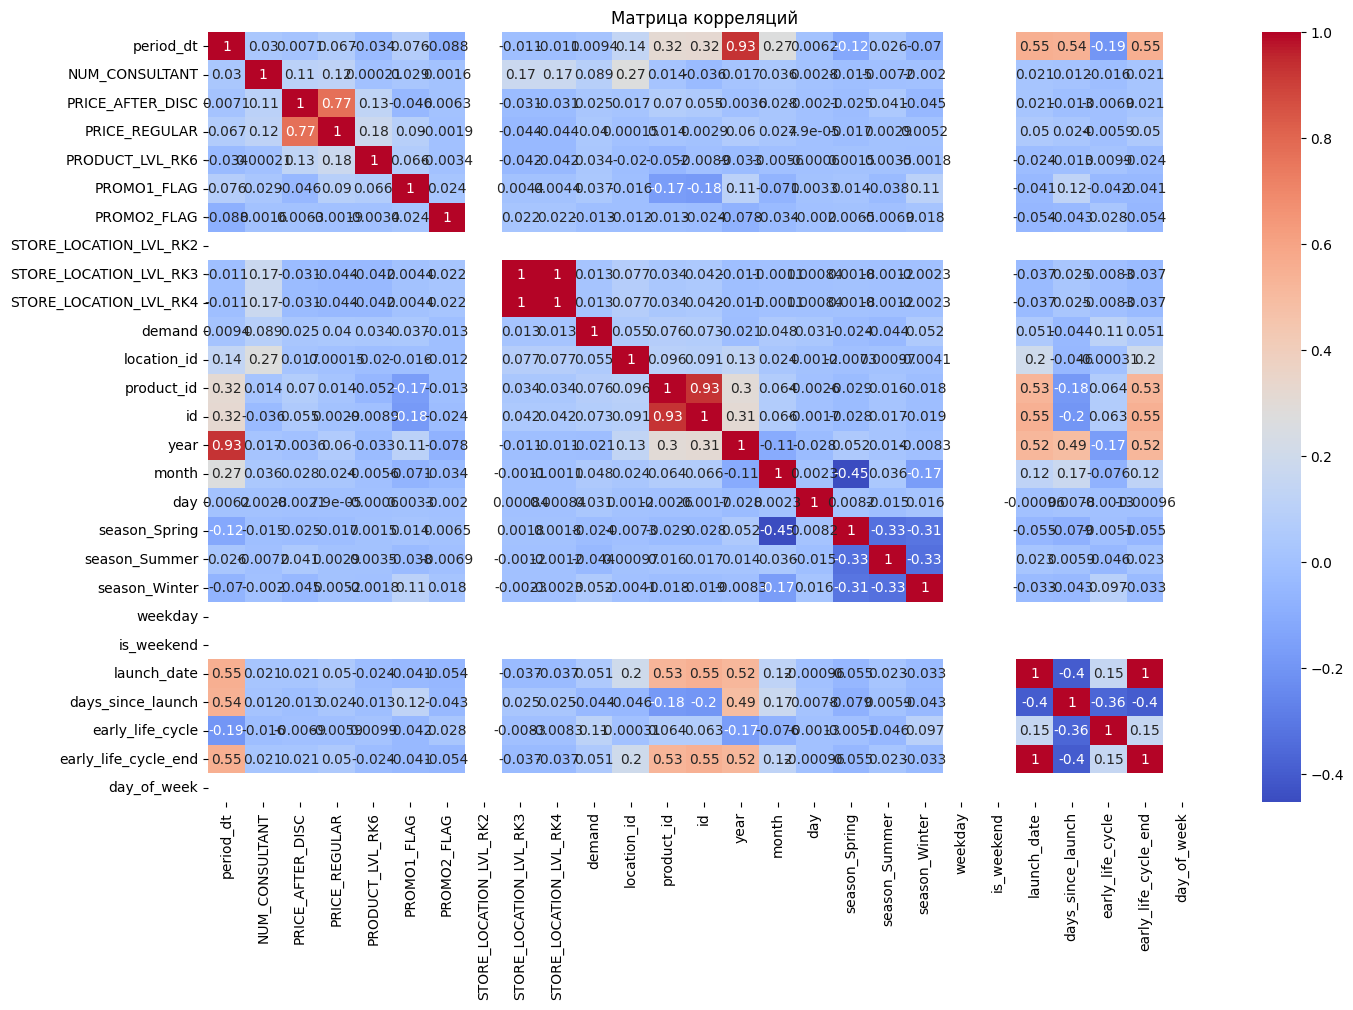

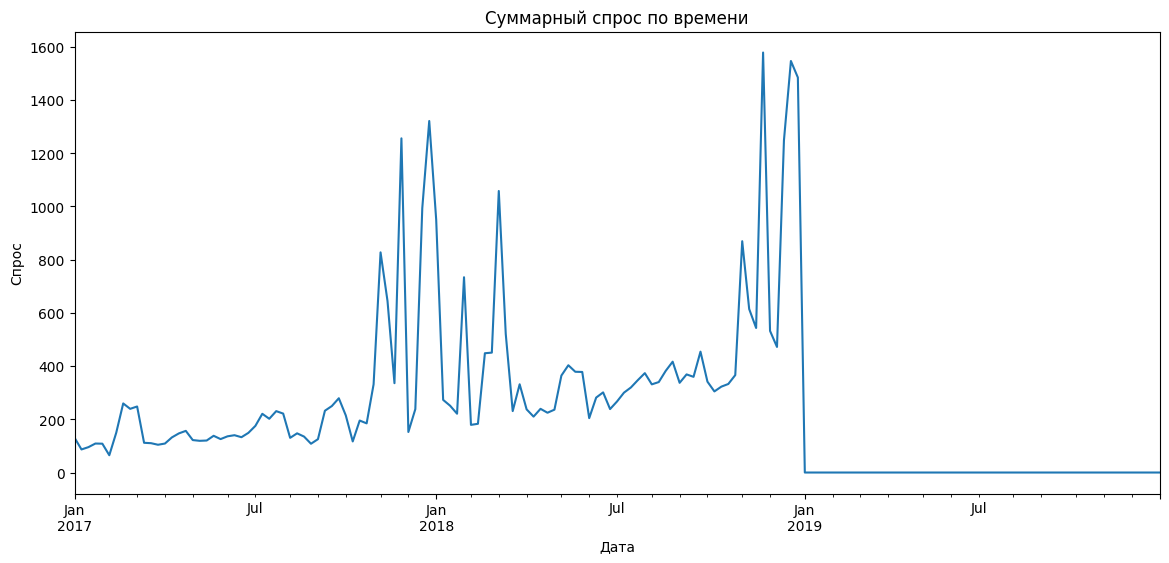

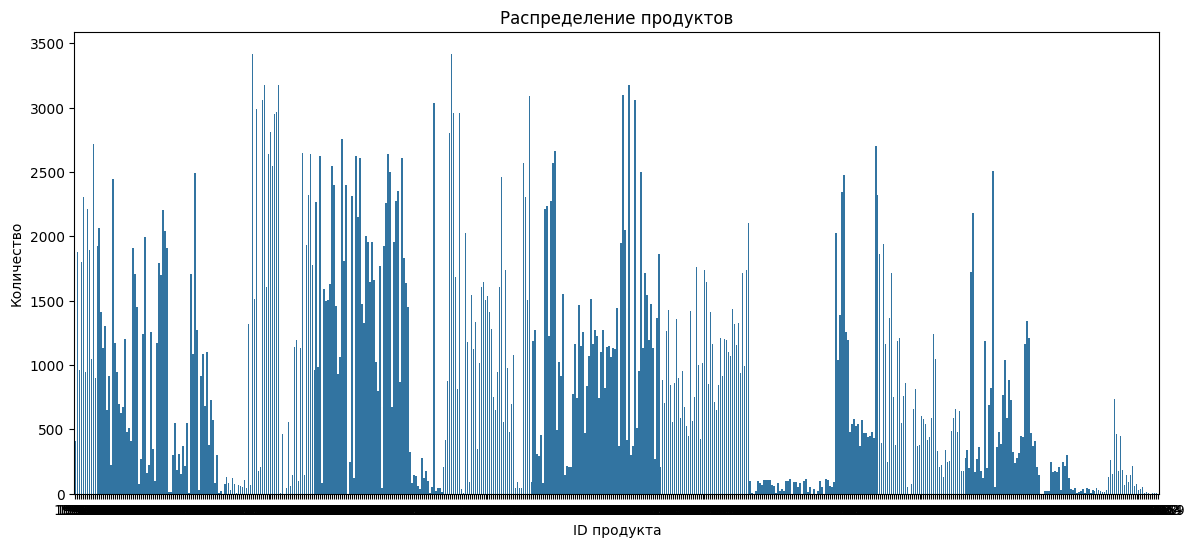

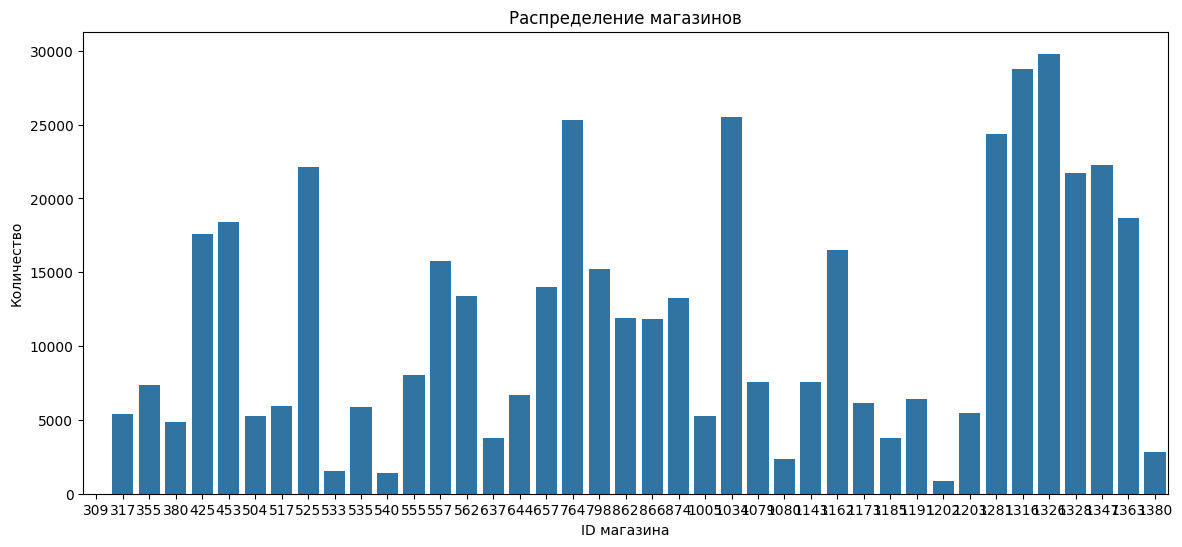

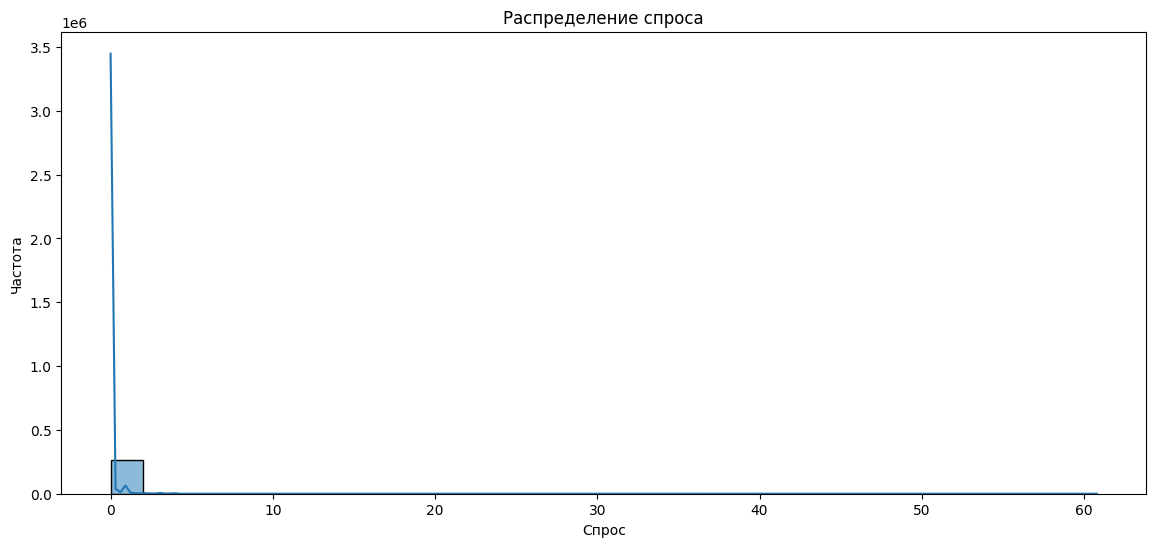

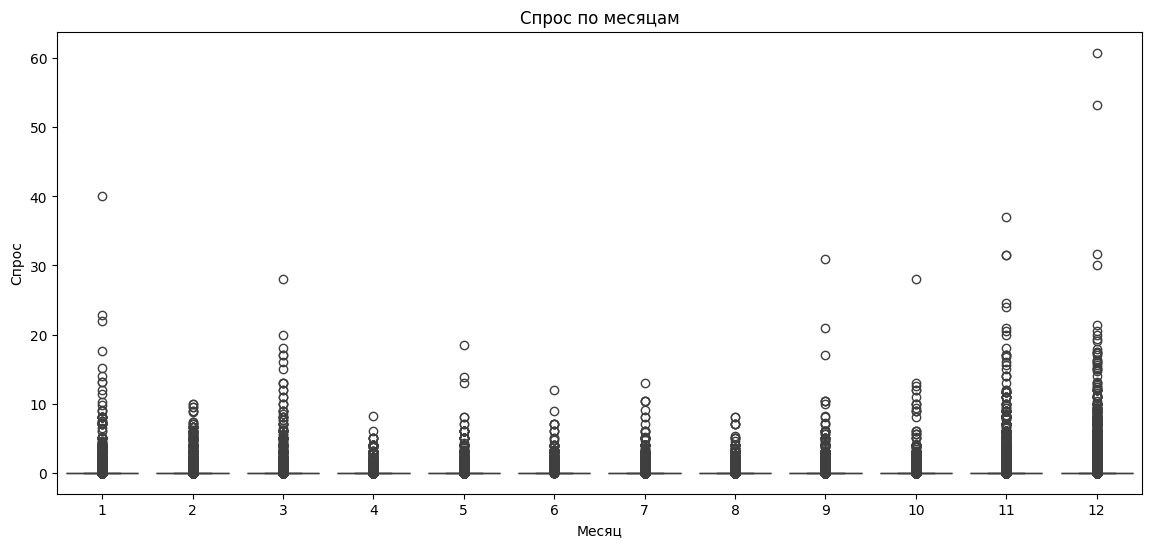

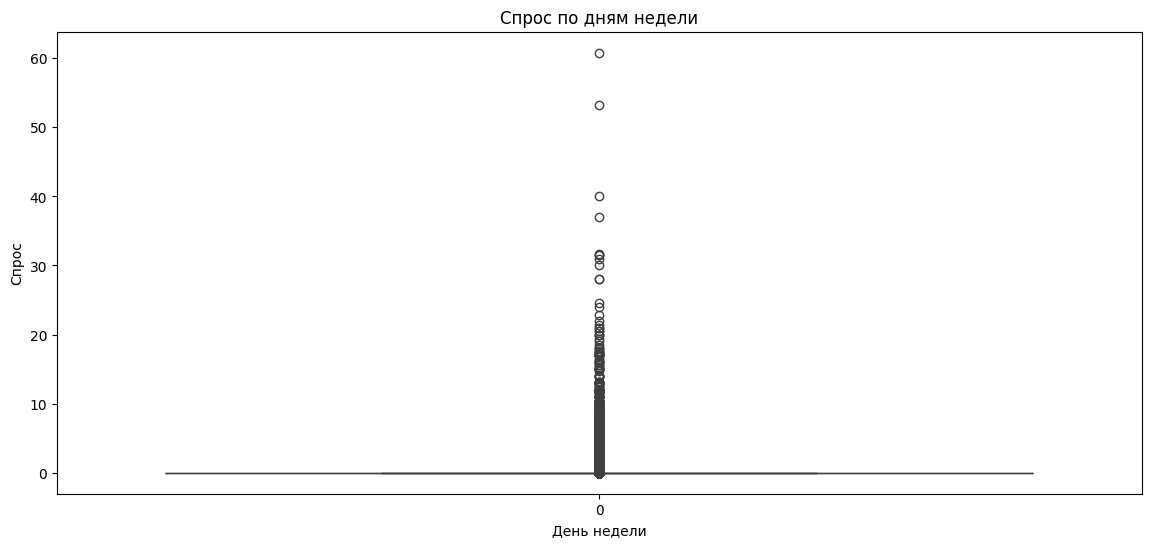

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns


# Анализ корреляций
corr_matrix = train_df.corr()
plt.figure(figsize=(16, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляций')
plt.show()

# Анализ временных рядов
plt.figure(figsize=(14, 6))
train_df.groupby('period_dt')['demand'].sum().plot()
plt.title('Суммарный спрос по времени')
plt.xlabel('Дата')
plt.ylabel('Спрос')
plt.show()

# Анализ категориальных признаков
plt.figure(figsize=(14, 6))
sns.countplot(data=train_df, x='product_id')
plt.title('Распределение продуктов')
plt.xlabel('ID продукта')
plt.ylabel('Количество')
plt.show()

plt.figure(figsize=(14, 6))
sns.countplot(data=train_df, x='location_id')
plt.title('Распределение магазинов')
plt.xlabel('ID магазина')
plt.ylabel('Количество')
plt.show()

# Анализ целевой переменной (спрос)
plt.figure(figsize=(14, 6))
sns.histplot(train_df['demand'], bins=30, kde=True)
plt.title('Распределение спроса')
plt.xlabel('Спрос')
plt.ylabel('Частота')
plt.show()

# Проверка сезонных компонентов
train_df['year'] = train_df['period_dt'].dt.year
train_df['month'] = train_df['period_dt'].dt.month
train_df['day_of_week'] = train_df['period_dt'].dt.dayofweek

plt.figure(figsize=(14, 6))
sns.boxplot(data=train_df, x='month', y='demand')
plt.title('Спрос по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Спрос')
plt.show()

plt.figure(figsize=(14, 6))
sns.boxplot(data=train_df, x='day_of_week', y='demand')
plt.title('Спрос по дням недели')
plt.xlabel('День недели')
plt.ylabel('Спрос')
plt.show()


##Preprocessing data


In [6]:
def get_season(date):
    if date.month in [12, 1, 2]:
        return 'Winter'
    elif date.month in [3, 4, 5]:
        return 'Spring'
    elif date.month in [6, 7, 8]:
        return 'Summer'
    elif date.month in [9, 10, 11]:
        return 'Fall'

In [7]:
train_df['period_dt'] = pd.to_datetime(train_df['period_dt'])
test_df['period_dt'] = pd.to_datetime(test_df['period_dt'])

In [8]:
train_df['year'] = train_df['period_dt'].dt.year
train_df['month'] = train_df['period_dt'].dt.month
train_df['day'] = train_df['period_dt'].dt.day

In [9]:
test_df['year'] = test_df['period_dt'].dt.year
test_df['month'] = test_df['period_dt'].dt.month
test_df['day'] = test_df['period_dt'].dt.day

In [10]:
train_df['season'] = train_df['period_dt'].apply(get_season)
test_df['season'] = test_df['period_dt'].apply(get_season)

In [11]:
train_df = pd.get_dummies(train_df, columns=['season'], drop_first=1)
test_df = pd.get_dummies(test_df, columns=['season'], drop_first=1)

In [12]:
for col in set(train_df.columns) - set(test_df.columns):
    if col.startswith('season_'):
        test_df[col] = 0

In [13]:
for col in set(test_df.columns) - set(train_df.columns):
    if col.startswith('season_'):
        train_df[col] = 0

In [14]:
train_df['season_Spring'] = train_df['season_Spring'].astype(int)
train_df['season_Summer'] = train_df['season_Summer'].astype(int)
train_df['season_Winter'] = train_df['season_Winter'].astype(int)

In [15]:
test_df['season_Spring'] = test_df['season_Spring'].astype(int)
test_df['season_Summer'] = test_df['season_Summer'].astype(int)
test_df['season_Winter'] = test_df['season_Winter'].astype(int)

In [16]:
train_df["weekday"] = train_df.period_dt.dt.weekday
train_df['is_weekend'] = train_df['weekday'].isin([5, 6]) * 1

In [17]:
test_df["weekday"] = test_df.period_dt.dt.weekday
test_df['is_weekend'] = test_df['weekday'].isin([5, 6]) * 1

In [18]:
train_df

,period_dt,NUM_CONSULTANT,PRICE_AFTER_DISC,PRICE_REGULAR,PRODUCT_LVL_RK6,PROMO1_FLAG,PROMO2_FLAG,STORE_LOCATION_LVL_RK2,STORE_LOCATION_LVL_RK3,STORE_LOCATION_LVL_RK4,...,product_id,id,year,month,day,season_Spring,season_Summer,season_Winter,weekday,is_weekend
0,2019-04-08,0.0,1049.00,1049.0,9988,1.0,0.0,10,203,203,...,19474,0,2019,4,8,1,0,0,0,0
1,2017-05-08,0.0,474.50,949.0,9988,0.0,0.0,10,189,189,...,19474,1,2017,5,8,1,0,0,0,0
2,2017-05-15,0.0,474.50,949.0,9988,0.0,0.0,10,189,189,...,19474,2,2017,5,15,1,0,0,0,0
3,2017-05-22,0.0,474.50,949.0,9988,0.0,0.0,10,189,189,...,19474,3,2017,5,22,1,0,0,0,0
4,2017-05-29,0.0,474.50,949.0,9988,1.0,0.0,10,189,189,...,19474,4,2017,5,29,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550139,2019-12-23,0.0,699.50,1399.0,113176,1.0,0.0,10,203,203,...,148464,550139,2019,12,23,0,0,1,0,0
550140,2019-12-30,0.0,699.50,1399.0,113176,1.0,0.0,10,203,203,...,148464,550140,2019,12,30,0,0,1,0,0
550141,2019-12-23,0.0,699.50,1399.0,113176,1.0,0.0,10,219,219,...,148464,550141,2019,12,23,0,0,1,0,0
550142,2019-12-30,0.0,699.50,1399.0,113176,1.0,0.0,10,219,219,...,148464,550142,2019,12,30,0,0,1,0,0


In [19]:
test_df

,product_id,location_id,period_dt,id,year,month,day,season_Spring,season_Summer,season_Winter,weekday,is_weekend
0,19474,425,2019-04-08,0,2019,4,8,1,0,0,0,0
1,19581,862,2019-04-08,1772,2019,4,8,1,0,0,0,0
2,19581,862,2019-04-15,1773,2019,4,15,1,0,0,0,0
3,19581,862,2019-04-22,1774,2019,4,22,1,0,0,0,0
4,19581,862,2019-04-29,1775,2019,4,29,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
34102,148464,1326,2019-12-23,550139,2019,12,23,0,0,1,0,0
34103,148464,1326,2019-12-30,550140,2019,12,30,0,0,1,0,0
34104,148464,1380,2019-12-23,550141,2019,12,23,0,0,1,0,0
34105,148464,1380,2019-12-30,550142,2019,12,30,0,0,1,0,0


In [20]:
train_df = train_df.sort_values(by=['product_id', 'location_id', 'period_dt'])
test_df = test_df.sort_values(by=['product_id', 'location_id', 'period_dt'])

product_launch_dates = train_df.groupby(['product_id', 'location_id'])['period_dt'].min().reset_index()
product_launch_dates.columns = ['product_id', 'location_id', 'launch_date']

train_df = train_df.merge(product_launch_dates, on=['product_id', 'location_id'], how='left')
test_df = test_df.merge(product_launch_dates, on=['product_id', 'location_id'], how='left')

train_df['days_since_launch'] = (train_df['period_dt'] - train_df['launch_date']).dt.days
test_df['days_since_launch'] = (test_df['period_dt'] - test_df['launch_date']).dt.days

In [21]:
train_df = train_df[~((train_df['launch_date'] >= '2016-12-01') & (train_df['launch_date'] <= '2017-01-01'))]

train_df['early_life_cycle'] = train_df['days_since_launch'].between(0, 28)  # 4 weeks as 28 days


cutoff_date = '2017-12-30'

train_df['early_life_cycle_end'] = train_df['launch_date'] + pd.to_timedelta(28, unit='d')


cutoff_date = pd.to_datetime('2017-12-30')
old_products = train_df[train_df['early_life_cycle_end'] < cutoff_date]

<ipython-input-21-b625147108fa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['early_life_cycle'] = train_df['days_since_launch'].between(0, 28)  # 4 weeks as 28 days
<ipython-input-21-b625147108fa>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['early_life_cycle_end'] = train_df['launch_date'] + pd.to_timedelta(28, unit='d')


In [22]:

old_products = old_products.dropna()


In [23]:
old_products

,period_dt,NUM_CONSULTANT,PRICE_AFTER_DISC,PRICE_REGULAR,PRODUCT_LVL_RK6,PROMO1_FLAG,PROMO2_FLAG,STORE_LOCATION_LVL_RK2,STORE_LOCATION_LVL_RK3,STORE_LOCATION_LVL_RK4,...,day,season_Spring,season_Summer,season_Winter,weekday,is_weekend,launch_date,days_since_launch,early_life_cycle,early_life_cycle_end
1,2017-05-08,0.0,474.5,949.0,9988,0.0,0.0,10,189,189,...,8,1,0,0,0,0,2017-05-08,0,True,2017-06-05
2,2017-05-15,0.0,474.5,949.0,9988,0.0,0.0,10,189,189,...,15,1,0,0,0,0,2017-05-08,7,True,2017-06-05
3,2017-05-22,0.0,474.5,949.0,9988,0.0,0.0,10,189,189,...,22,1,0,0,0,0,2017-05-08,14,True,2017-06-05
4,2017-05-29,0.0,474.5,949.0,9988,1.0,0.0,10,189,189,...,29,1,0,0,0,0,2017-05-08,21,True,2017-06-05
5,2017-06-05,0.0,474.5,949.0,9988,1.0,0.0,10,189,189,...,5,0,1,0,0,0,2017-05-08,28,True,2017-06-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508174,2018-12-03,5.0,1749.5,3499.0,113176,0.0,0.0,10,203,203,...,3,0,0,1,0,0,2017-11-27,371,False,2017-12-25
508175,2018-12-10,5.0,1749.5,3499.0,113176,0.0,0.0,10,203,203,...,10,0,0,1,0,0,2017-11-27,378,False,2017-12-25
508176,2018-12-17,5.0,1749.5,3499.0,113176,0.0,0.0,10,203,203,...,17,0,0,1,0,0,2017-11-27,385,False,2017-12-25
508177,2018-12-24,5.0,1749.5,3499.0,113176,0.0,0.0,10,203,203,...,24,0,0,1,0,0,2017-11-27,392,False,2017-12-25


In [24]:
unique_counts = old_products.nunique()
percent_unique = (unique_counts / len(old_products)) * 100
zero_counts = (old_products == 0).sum()
percent_zero = (zero_counts / len(old_products)) * 100
null_counts = old_products.isnull().sum()
percent_null = (null_counts / len(old_products)) * 100

In [25]:
summary_df = pd.DataFrame({
        'Column': old_products.columns,
        'Unique': unique_counts,
        '%unique': percent_unique,
        'Zero': zero_counts,
        '%zero': percent_zero,
        'Null': null_counts,
        '%null': percent_null
    })

In [26]:
summary_df

,Column,Unique,%unique,Zero,%zero,Null,%null
period_dt,period_dt,105,0.057330,0,0.000000,0,0.0
NUM_CONSULTANT,NUM_CONSULTANT,8,0.004368,166369,90.838061,0,0.0
PRICE_AFTER_DISC,PRICE_AFTER_DISC,3266,1.783248,0,0.000000,0,0.0
PRICE_REGULAR,PRICE_REGULAR,795,0.434073,0,0.000000,0,0.0
PRODUCT_LVL_RK6,PRODUCT_LVL_RK6,13,0.007098,0,0.000000,0,0.0
PROMO1_FLAG,PROMO1_FLAG,3,0.001638,54731,29.883319,0,0.0
PROMO2_FLAG,PROMO2_FLAG,2,0.001092,181825,99.277091,0,0.0
STORE_LOCATION_LVL_RK2,STORE_LOCATION_LVL_RK2,1,0.000546,0,0.000000,0,0.0
STORE_LOCATION_LVL_RK3,STORE_LOCATION_LVL_RK3,13,0.007098,0,0.000000,0,0.0
STORE_LOCATION_LVL_RK4,STORE_LOCATION_LVL_RK4,13,0.007098,0,0.000000,0,0.0


In [27]:
unique_pairs = old_products[['product_id', 'location_id']].drop_duplicates()
num_unique_pairs = len(unique_pairs)

In [28]:
num_unique_pairs

2823

In [29]:
unique_pairs_test = test_df[['product_id', 'location_id']].drop_duplicates()
num_unique_pairs_test = len(unique_pairs_test)

In [30]:
num_unique_pairs_test

2790

In [25]:
test_df

,product_id,location_id,period_dt,id,year,month,day,season_Spring,season_Summer,season_Winter,weekday,is_weekend,launch_date,days_since_launch
0,19474,425,2019-04-08,0,2019,4,8,1,0,0,0,0,2019-04-08,0
1,19581,862,2019-04-08,1772,2019,4,8,1,0,0,0,0,2019-04-08,0
2,19581,862,2019-04-15,1773,2019,4,15,1,0,0,0,0,2019-04-08,7
3,19581,862,2019-04-22,1774,2019,4,22,1,0,0,0,0,2019-04-08,14
4,19581,862,2019-04-29,1775,2019,4,29,1,0,0,0,0,2019-04-08,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34102,148464,1326,2019-12-23,550139,2019,12,23,0,0,1,0,0,2019-12-16,7
34103,148464,1326,2019-12-30,550140,2019,12,30,0,0,1,0,0,2019-12-16,14
34104,148464,1380,2019-12-23,550141,2019,12,23,0,0,1,0,0,2019-12-23,0
34105,148464,1380,2019-12-30,550142,2019,12,30,0,0,1,0,0,2019-12-23,7


In [26]:
unique_w_tr = train_df['weekday'].nunique()
unique_w_test = test_df['weekday'].nunique()

In [27]:
unique_w_tr

1

In [28]:
unique_w_test

1

In [29]:
train_df = train_df.drop('weekday', axis=1)
train_df = train_df.drop('is_weekend', axis=1)

In [30]:
test_df = test_df.drop('weekday', axis=1)
test_df = test_df.drop('is_weekend', axis=1)

In [31]:
features = ['location_id', 'product_id', 'days_since_launch', 'year', 'month', 'day', 'season_Spring', 'season_Summer', 'season_Winter']
target = 'demand'

##Models

In [34]:
X_train = old_products[features]
y_train = old_products[target]

In [38]:
X_test = test_df[features]

In [37]:
model_rf = RandomForestRegressor(random_state=1, n_estimators=100, max_depth=10, min_samples_leaf=2, min_samples_split=5)

# Обучение модели на всех данных
model_rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                      random_state=1)

In [39]:
y_pred2 = model_rf.predict(X_test)

In [40]:
predictions2 = pd.DataFrame({
    'id': test_df['id'],
    'demand': y_pred2
})

In [41]:
predictions2.to_csv('submission_rf.csv',sep=',', encoding='utf-8', index=False)

In [42]:
model_gb = GradientBoostingRegressor(random_state=1)

# Обучение модели на всех данных
model_gb.fit(X_train, y_train)


GradientBoostingRegressor(random_state=1)

In [43]:
y_pred1 = model_gb.predict(X_test)

In [45]:
predictions1 = pd.DataFrame({
    'id': test_df['id'],
    'demand': y_pred1
})

In [46]:
predictions1.to_csv('submission_gb.csv',sep=',', encoding='utf-8', index=False)

In [ ]:
regressor = GradientBoostingRegressor(random_state=1)


In [ ]:
param_grid_gb = {
    'max_depth': [6, 8, 10, 11],
    'n_estimators': [300, 350, 400, 420],
    'learning_rate': [0.1, 0.15, 0.2, 0.25],
    'min_samples_leaf': [5, 10, 11, 12],
    'min_samples_split': [2, 5, 10],
    'loss': ['absolute_error', 'squared_error']
}

grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error')


grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=1),
             n_jobs=-1,
             param_grid={'max_depth': [8, 10, 11],
                         'n_estimators': [340, 420, 560]},
             scoring='neg_mean_absolute_error', verbose=2)

In [ ]:
best_model = grid_search.best_estimator_

print(f"Лучшие параметры: {grid_search.best_params_}")

In [ ]:
best_model_gb = GradientBoostingRegressor(
    max_depth=11,
    n_estimators=420,
    learning_rate=0.2,
    random_state=1,
    min_samples_leaf=11,
    min_samples_split=2,
    loss='absolute_error'
)
best_model_gb.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.2, loss='absolute_error',
                          max_depth=11, min_samples_leaf=11, n_estimators=420,
                          random_state=1)

In [ ]:
y_pred = best_model_gb.predict(X_test)

In [ ]:
y_pred

array([1.        , 1.        , 0.        , ..., 1.        , 1.83370587,
       1.        ])

In [ ]:
predictions = pd.DataFrame({
    'id': test_df['id'],
    'demand': y_pred2
})

In [ ]:
predictions

,id,demand
0,0,1.000000
1,1772,1.000000
2,1773,0.000000
3,1774,0.000000
4,1775,0.000000
...,...,...
34102,550139,2.025099
34103,550140,1.833706
34104,550141,1.000000
34105,550142,1.833706


In [ ]:
predictions.to_csv('submission_gb.csv',sep=',', encoding='utf-8', index=False)

In [ ]:
# Определение и обучение модели RandomForestRegressor
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [6, 8, 10, 12],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

,product_id,location_id,period_dt,id,launch_date_x,launch_date_y,launch_date,days_since_launch
0,23289,1316,2019-02-25,281741,2019-02-25,2019-02-25,2019-02-25,0
1,23296,317,2019-02-04,282560,2019-02-04,2019-02-04,2019-02-04,0
2,23297,317,2019-01-21,601,2019-01-21,2019-01-21,2019-01-21,0
3,23297,644,2019-01-28,697,2019-01-28,2019-01-28,2019-01-28,0
4,23297,1162,2019-01-14,831,2019-01-14,2019-01-14,2019-01-14,0
...,...,...,...,...,...,...,...,...
10164,149468,1316,2019-11-04,408047,2019-11-04,2019-11-04,2019-11-04,0
10165,149488,1316,2019-11-04,272768,2019-11-04,2019-11-04,2019-11-04,0
10166,149489,1316,2019-11-11,272775,2019-11-11,2019-11-11,2019-11-11,0
10167,149490,1316,2019-11-25,272780,2019-11-25,2019-11-25,2019-11-25,0


##Draft

In [ ]:
X_train

,location_id,product_id,days_since_launch
5,355.0,23252.0,7.0
6,525.0,23252.0,7.0
7,657.0,23252.0,7.0
8,798.0,23252.0,7.0
10,317.0,23252.0,14.0
...,...,...,...
363699,1328.0,101079.0,35.0
363700,557.0,101079.0,371.0
363701,557.0,101079.0,378.0
363702,1328.0,101079.0,385.0


In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred

array([0.82800186, 0.82826603, 0.83524963, ..., 1.68437776, 0.45727421,
       1.68437776])

In [ ]:
predictions = pd.DataFrame({
    'id': test_df['id'],
    'demand': y_pred
})

In [ ]:
predictions

,id,demand
0,601,0.828002
1,697,0.828266
2,831,0.835250
3,875,1.147369
4,975,0.828266
...,...,...
10164,408050,1.684378
10165,408051,1.684378
10166,408052,1.684378
10167,408053,0.457274


In [ ]:
predictions.to_csv('submission.csv',sep=',', encoding='utf-8', index=False)